# Project - IsoChroma

The goal of this project is to mathematically determine the best text color to maintain visual consistency with a background color, compared to another foreground/background color pair. The use case: the hyperlinks in my résumé are sky blue on a white background, and parts of my résumé uses a dark blue background. Which color should be used for the hyperlinks on this dark blue section to maintain visual consistency ?

This notebook details the various conclusions I reached during my research on color spaces and contrast throughout this one-week project. It is important to note that some results are inaccurate, and some color spaces do not work properly: the goal was not to write fully functional code, but rather to apply the theoretical information I found and obtain a usable result within the project time-limit.

Since the purpose of this notebook is to present my findings rather than the formulas or concepts used, if you are interested, I invite you to consult the code or the various links shared throughout.

Here is the reference foreground/background pair, with a rough estimate of the text color we should be aiming for :

In [1]:
import numpy as np

from src.spaces.rgb import RGB
from src.utils import print_fg_bg

rgb_src_bg = RGB(np.array([1.0, 1.0, 1.0], dtype=np.float64))
rgb_src_fg = RGB(np.array([0.0784313725490196, 0.33725490196078434, 0.5019607843137255], dtype=np.float64))
rgb_trg_bg = RGB(np.array([0.18823529411764706, 0.25882352941176473, 0.38823529411764707], dtype=np.float64))
print_fg_bg(rgb_src_bg, rgb_src_fg, "Reference for regular distances")

rgb_trg_fg_est = RGB(np.array([219 / 255, 232 / 255, 255 / 255], dtype=np.float64))
print_fg_bg(rgb_trg_bg, rgb_trg_fg_est, "Manual Estimation")

Reference for regular distances                   [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Manual Estimation                                    [48 66 99]/[219 232 255] | #304263/#DBE8FF


### I. RGB, XYZ and LMS color spaces


My first intuition was to assume that a simple Euclidean distance/linear application on a proper color space would be enough to determine *target_fg* from the variables *source_bg*, *source_fg*, and *target_bg*. However, the RGB color space — although particularly useful for storing information or displaying images on a screen — is not well suited for this type of calculation, since it does not reflect the way our eyes actually perceive colors. As you can see, trying to maintain the color ratios results in pretty bad foreground color.

In [2]:
print_fg_bg(rgb_src_bg, rgb_src_fg, "Reference for regular distances")
print_fg_bg(rgb_trg_bg, rgb_trg_fg_est, "Manual Estimation")

rgb_trg_fg_rgb = rgb_trg_bg + (rgb_src_bg - rgb_src_fg)
print_fg_bg(rgb_trg_bg, rgb_trg_fg_rgb, "RGB")

rgb_trg_fg_r = rgb_trg_bg * rgb_src_fg / rgb_src_bg
print_fg_bg(rgb_trg_bg, rgb_trg_fg_r, "RGB (ratio)")

rgb_trg_fg_ir = rgb_trg_bg * rgb_src_bg / rgb_src_fg
print_fg_bg(rgb_trg_bg, rgb_trg_fg_ir, "RGB (inverted ratio)")

Reference for regular distances                   [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Manual Estimation                                    [48 66 99]/[219 232 255] | #304263/#DBE8FF
RGB                                                  [48 66 99]/[255 235 226] | #304263/#FFEBE2
RGB (ratio)                                          [48 66 99]/[ 4 22 50]    | #304263/#041632
RGB (inverted ratio)                                 [48 66 99]/[255 196 197] | #304263/#FFC4C5


This is why I tried the same method, applied to color spaces that are closer to human perception. The first one I explored was the [LMS](https://en.wikipedia.org/wiki/LMS_color_space) color space, which represents the responses of the different cones in the human eye. However, there is no direct method to convert from RGB to LMS, so it is first necessary to convert RGB to the [XYZ](https://fr.wikipedia.org/wiki/CIE_XYZ) color space. To do this, I relied on the formulas and calculations from Bruce Lindbloom’s excellent website—particularly the sections on the [RGB color space](http://www.brucelindbloom.com/index.html?WorkingSpaceInfo.html), [Chromatic Adaptation](http://www.brucelindbloom.com/index.html?Eqn_ChromAdapt.html) and the [RGB/XYZ Conversion Matrices](http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html).

Unfortunately, the conversion does not seem to work properly or yields unsatisfactory results. Several possibilities remain to be explored, such as gamut mapping, potential errors in my chromatic adaptation calculus, or mistakes in the conversion calculations.

*(Interestingly, the ratios seem similar between RGB and LMS)*

In [3]:
print_fg_bg(rgb_src_bg, rgb_src_fg, "Reference for regular distances")
print_fg_bg(rgb_trg_bg, rgb_trg_fg_est, "Manual Estimation")

rgb_trg_fg_lms = (rgb_trg_bg.to_lms() + (rgb_src_fg.to_lms() - rgb_src_bg.to_lms())).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_lms, "LMS", "!!!Cliping")

rgb_trg_fg_lms_r = (rgb_trg_bg.to_lms() * rgb_src_fg.to_lms() / rgb_src_bg.to_lms()).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_lms_r, "LMS (ratio)")

rgb_trg_fg_lms_ir = (rgb_trg_bg.to_lms() * rgb_src_bg.to_lms() / rgb_src_fg.to_lms()).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_lms_ir, "LMS (inverted ratio)")

rgb_trg_fg_lms_nb = (
    rgb_trg_bg.to_lms(bradford_adapted_d50=False)
    + (rgb_src_bg.to_lms(bradford_adapted_d50=False) - rgb_src_fg.to_lms(bradford_adapted_d50=False))
).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_lms_nb, "LMS (and no Bradford adaptation)")

Reference for regular distances                   [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Manual Estimation                                    [48 66 99]/[219 232 255] | #304263/#DBE8FF
LMS                                                  [48 66 99]/[0 0 0]       | #304263/#000000!!!Cliping
LMS (ratio)                                          [48 66 99]/[ 0 22 49]    | #304263/#001631
LMS (inverted ratio)                                 [48 66 99]/[255 192 197] | #304263/#FFC0C5
LMS (and no Bradford adaptation)                     [48 66 99]/[131 255 255] | #304263/#83FFFF


### II. HSL, HSV and OkLab

After a discussion with a friend who specializes in image processing, I realized that a linear transformation — regardless of the color space — would struggle to meet the goal of this project. I also learned that cylindrical color spaces might be better suited for these calculations, particularly because lighting is a component in its own right in those spaces.

This led me to quickly re-implement the [HSL and HSV](https://en.wikipedia.org/wiki/HSL_and_HSV) color spaces, before discovering, to my great surprise, that Python’s standard library already includes conversion functions for these spaces ([*colorsys*](https://docs.python.org/fr/3/library/colorsys.html)). Once again, attempting to reproduce cylindrical distance did not seem to yield satisfactory results. However, inverting the lightness component produces a ratio that is closer to the visual estimate than anything I had obtained previously.

In [4]:
from src.spaces.hsl import HSLstd

print_fg_bg(rgb_src_bg, rgb_src_fg, "Reference for regular distances")
print_fg_bg(rgb_trg_bg, rgb_trg_fg_est, "Manual Estimation")

rgb_trg_fg_hsl = (rgb_trg_bg.to_hsl() + (rgb_src_bg.to_hsl() - rgb_src_fg.to_hsl())).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_hsl, "HSL", "!!!Cliping (inconsistent with std)")

rgb_trg_fg_hslstd = (rgb_trg_bg.to_hslstd() + (rgb_src_bg.to_hslstd() - rgb_src_fg.to_hslstd())).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_hslstd, "HSLstd")

rgb_trg_fg_hslstd_il = HSLstd([*rgb_trg_bg.to_hslstd().values[:2], 1 - rgb_trg_bg.to_hslstd().values[2]]).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_hslstd_il, "HSLstd invert lightness")

rgb_trg_fg_hsv = (rgb_trg_bg.to_hsv() + (rgb_src_bg.to_hsv() - rgb_src_fg.to_hsv())).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_hsv, "HSV")

rgb_trg_fg_hsvstd = (rgb_trg_bg.to_hsvstd() + (rgb_src_bg.to_hsvstd() - rgb_src_fg.to_hsvstd())).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_hsvstd, "HSVstd")

Reference for regular distances                   [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Manual Estimation                                    [48 66 99]/[219 232 255] | #304263/#DBE8FF
HSL                                                  [48 66 99]/[0 0 0]       | #304263/#000000!!!Cliping (inconsistent with std)
HSLstd                                               [48 66 99]/[254 254 255] | #304263/#FEFEFF
HSLstd invert lightness                              [48 66 99]/[156 174 207] | #304263/#9CAECF
HSV                                                  [48 66 99]/[253 226 255] | #304263/#FDE2FF
HSVstd                                               [48 66 99]/[253 226 255] | #304263/#FDE2FF


After discussing the topic again with my friend, I wanted to make one last attempt to see whether my initial intuition was correct by implementing conversions to the [OkLab](https://en.wikipedia.org/wiki/Oklab_color_space) color space, which has seemingly become a standard in the field over the past few years. Once again, the results were disappointing.

In [5]:
print_fg_bg(rgb_src_bg, rgb_src_fg, "Reference for regular distances")
print_fg_bg(rgb_trg_bg, rgb_trg_fg_est, "Manual Estimation")

rgb_trg_fg_oklab = (
    (rgb_trg_bg.to_xyz().to_oklab() + (rgb_src_bg.to_xyz().to_oklab() - rgb_src_fg.to_xyz().to_oklab())).to_xyz()
).to_rgb()
print_fg_bg(rgb_trg_bg, rgb_trg_fg_oklab, "Oklab")

rgb_trg_fg_oklab_r = (
    (rgb_trg_bg.to_xyz().to_oklab() * rgb_src_fg.to_xyz().to_oklab() / rgb_src_bg.to_xyz().to_oklab()).to_xyz().to_rgb()
)
print_fg_bg(rgb_trg_bg, rgb_trg_fg_oklab_r, "OkLab (ratio)")

rgb_trg_fg_oklab_ir = (
    (rgb_trg_bg.to_xyz().to_oklab() * rgb_src_bg.to_xyz().to_oklab() / rgb_src_fg.to_xyz().to_oklab()).to_xyz().to_rgb()
)
print_fg_bg(rgb_trg_bg, rgb_trg_fg_oklab_ir, "OkLab (inverted ratio)")

Reference for regular distances                   [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Manual Estimation                                    [48 66 99]/[219 232 255] | #304263/#DBE8FF
Oklab                                                [48 66 99]/[255 209 205] | #304263/#FFD1CD
OkLab (ratio)                                        [48 66 99]/[14 20 16]    | #304263/#0E1410
OkLab (inverted ratio)                               [48 66 99]/[255 139 231] | #304263/#FF8BE7


### III. Weber-Fechner Contrast

While reading blogs about OkLab and particularly about HSL/HSV, I eventually came across information on concepts related to perception and contrast preservation, specifically the [Weber-Fechner contrast](https://en.wikipedia.org/wiki/Contrast_(vision)#Quantifications). Since it was clear that a linear operation in any given color space was not sufficient, I needed a new metric to perform my calculations. The results were far more qualitative than those obtained with Euclidean or cylindrical distances.

The goal here was therefore to vary one of the variables of the HSL, HSV, and OkLab spaces and try to determine the relationship between these variables and the Weber–Fechner contrast. We therefore use luminance for the HSL and OkLab color spaces, and the value component for HSV. Surprisingly, the L variable in HSL and the V variable in HSV are linearly correlated with contrast: we can apply a simple linear regression on just a handful of samples to obtain the parameters of the equation and reach the most accurate result possible (see below, mean squared error between estimate and samples is zero). For OkLab luminance, however, an exponential curve appears to best match the sample curve (hence the *expfit* and the normalization (since WFC is [-1; +∞])).

We can therefore see at the end that by using the equation parameters obtained from the linear regressions, we get three Weber–Fechner contrast values that are particularly close to the reference contrast.

In [6]:
from src.contrast import weber_fechner_contrast, weber_fechner_expfit, weber_fechner_fit
from src.spaces.hsl import HSLstd
from src.spaces.hsv import HSVstd
from src.spaces.oklab import OKLAB

wfc_ref = weber_fechner_contrast(rgb_src_bg, rgb_src_fg)
wfc_est = weber_fechner_contrast(rgb_trg_bg, rgb_trg_fg_est)

print_fg_bg(rgb_src_bg, rgb_src_fg, f"Reference for Weber-Fechner contrast : {wfc_ref:.5f}")
print_fg_bg(rgb_trg_bg, rgb_trg_fg_est, f"Manual Estimation for Weber-Fechner : {wfc_ref:.5f}")

a, b, _ = weber_fechner_fit(rgb_src_fg, rgb_trg_bg, color_space_conv=RGB.to_hslstd, color_space_conv_inv=HSLstd.to_rgb)
rgb_trg_fg_wfc_hsl = HSLstd([*rgb_src_fg.to_hslstd().values[:2], (wfc_ref - b) / a]).to_rgb()
print_fg_bg(
    rgb_trg_bg,
    rgb_trg_fg_wfc_hsl,
    f"Weber Fechner fit (HSL) : {weber_fechner_contrast(rgb_trg_fg_wfc_hsl, rgb_trg_bg):.5f}",
)

a, b, _ = weber_fechner_fit(rgb_src_fg, rgb_trg_bg, color_space_conv=RGB.to_hsvstd, color_space_conv_inv=HSVstd.to_rgb)
rgb_trg_fg_wfc_hsv = HSVstd([*rgb_src_fg.to_hsvstd().values[:2], (wfc_ref - b) / a]).to_rgb()
print_fg_bg(
    rgb_trg_bg,
    rgb_trg_fg_wfc_hsv,
    f"Weber Fechner fit (HSV) : {weber_fechner_contrast(rgb_trg_fg_wfc_hsv, rgb_trg_bg):.5f}",
)

a, b, _ = weber_fechner_expfit(
    rgb_src_fg,
    rgb_trg_bg,
    color_space_conv=RGB.to_oklab,
    color_space_conv_inv=OKLAB.to_rgb,
    color_space_dim=0,
    normalize=True,
    weighted_least_squares=True,
)
exp_wfc = (np.log(wfc_ref + 1) - np.log(b)) / a
rgb_trg_fg_wfc_oklab = OKLAB([exp_wfc, *rgb_src_fg.to_oklab().values[1:]]).to_rgb()
print_fg_bg(
    rgb_trg_bg,
    rgb_trg_fg_wfc_oklab,
    f"Weber Fechner fit (OkLab) : {weber_fechner_contrast(rgb_trg_fg_wfc_oklab, rgb_trg_bg):.5f}",
)

Reference for Weber-Fechner contrast : 2.39996    [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Manual Estimation for Weber-Fechner : 2.39996        [48 66 99]/[219 232 255] | #304263/#DBE8FF
Weber Fechner fit (HSL) : 2.39514                    [48 66 99]/[192 225 245] | #304263/#C0E1F5
Weber Fechner fit (HSV) : 2.40968                    [48 66 99]/[ 59 252 255] | #304263/#3BFCFF
Weber Fechner fit (OkLab) : 2.22937                  [48 66 99]/[ 60 241 255] | #304263/#3CF1FF


It is quite interesting to examine the different curves produced by the linear regressions. Since the variables of the three color spaces used are bounded, it is entirely possible that no solution exists (at least when modifying **only one** variable) to reach the target contrast. Fortunately, in our case, a solution does exist in all three spaces. What is most noteworthy is that the higher the target contrast is (or more precisely, the greater the difference between the target contrast and *target_bg*), the more likely it becomes that a regression on a single variable will no longer be sufficient.

*I would also like to point out that L (for HSL and OkLab) is bounded within [0; 1], while V (for HSV) is bounded within [0; +∞]. Even though the solution for HSVstd(target) is not visible on the graph, it equals ~1.4.*

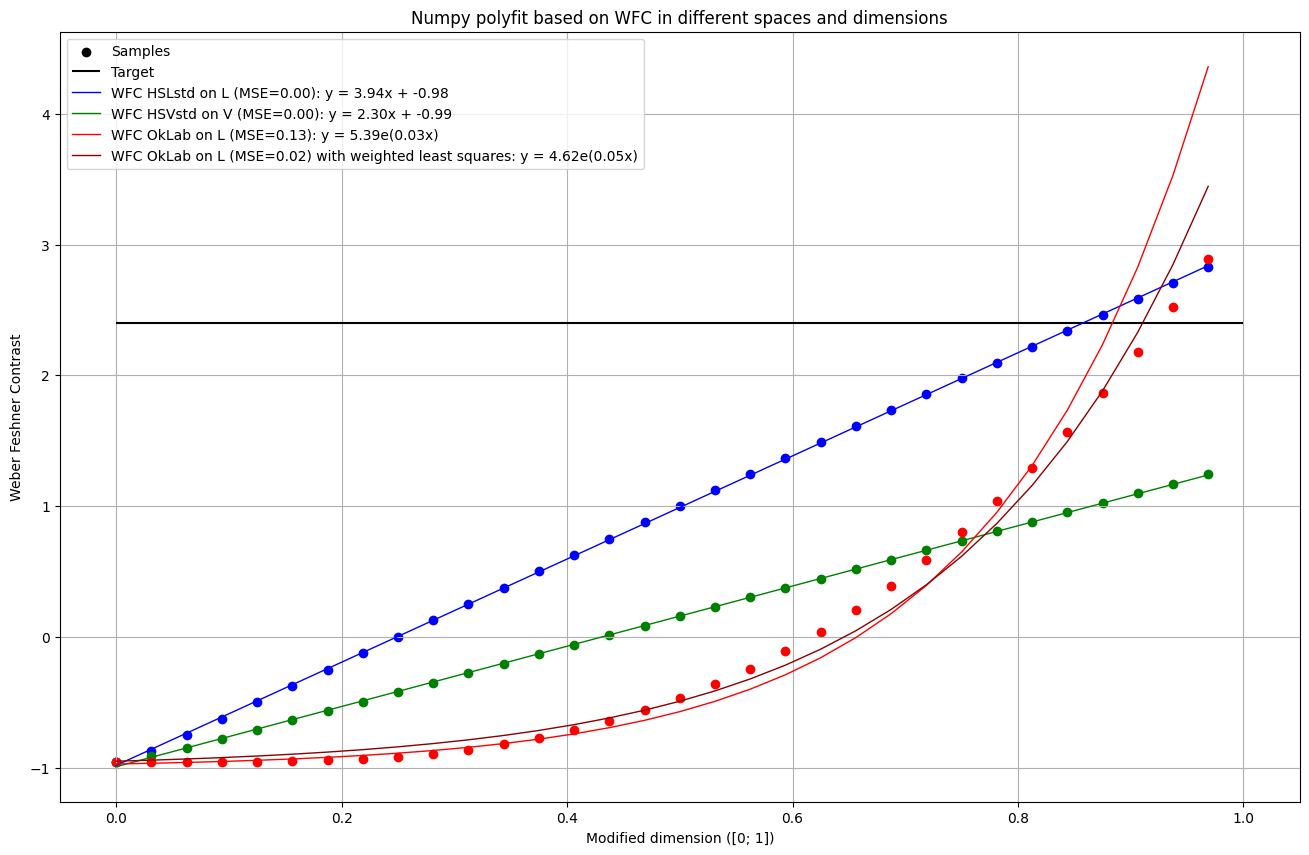

In [7]:
from src.plot import weber_fechner_plot

weber_fechner_plot(rgb_src_fg, rgb_trg_bg, wfc_ref)

In the end, since I had no mathematical way to choose between the three different values obtained, I asked several friends and colleagues to vote, which resulted in a victory for the HSL space (the other two were considered too “harsh” of a contrast on the eyes). Even though the contrast obtained with HSL was not the closest of the three, it is the one that was ultimately chosen.

In [8]:
print_fg_bg(rgb_src_bg, rgb_src_fg, f"Reference for Weber-Fechner contrast : {wfc_ref:.5f}")
print_fg_bg(
    rgb_trg_bg,
    rgb_trg_fg_wfc_hsl,
    f"Winner for Weber-Fechner contrast (HSL) : {weber_fechner_contrast(rgb_trg_fg_wfc_hsl, rgb_trg_bg):.5f}",
)

Reference for Weber-Fechner contrast : 2.39996    [255 255 255]/[ 20  86 128] | #FFFFFF/#145680
Winner for Weber-Fechner contrast (HSL) : 2.39514    [48 66 99]/[192 225 245] | #304263/#C0E1F5


### IV. Issues & Critics

- First of all, it is possible that some of my calculations are incorrect or do not accurately reflect my intentions. In addition, some formulas may be wrong. This is difficult to assess because the context of this project is quite specific: the *source_bg* is white (#FFFFFF, therefore the maximum of the rgb/hex color space), and *source_fg* and *target_bg* are both shades of blue that are relatively close to each other. It is therefore very likely that in a different context, the code would not be generic enough to produce satisfactory results.

- Even though the Weber–Fechner contrast seemed to be the most suitable for this project, it would be interesting to explore what results other contrast formulas might produce, such as the [Michelson contrast](https://en.wikipedia.org/wiki/Contrast_(vision)#Michelson_contrast) or the [RMS contrast](https://en.wikipedia.org/wiki/Contrast_(vision)#RMS_contrast).

- Regarding the linear regressions: there is probably a simpler and cleaner way to perform the calculations and draw conclusions. I simply chose the approach that felt the most natural and understandable for me.